**Nama : Wahyu Bagus Wicaksono**

**Grup : M07**

Import library yang diperlukan

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

Install library kaggle untuk mendownload dataset

In [ ]:
!pip install -q kaggle

Upload api key kamu yang sudah di download dari website kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yourbeagle","key":"f02c85b9e7db1548472d4345258abe36"}'}

untuk membuat folder .kaggle dan memberikan hak akses

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


Mendownload dataset dan mengekstrak zip folder


dataset bisa di download di : https://www.kaggle.com/datasets/mostafaabla/garbage-classification

In [4]:
!kaggle datasets download -d mostafaabla/garbage-classification -p /content/sample_data/ --unzip

 98% 234M/239M [00:06<00:00, 33.3MB/s]
100% 239M/239M [00:06<00:00, 38.2MB/s]


Melihat isi folder dari dataset tersebut

In [5]:
!ls /content/sample_data/garbage_classification

battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


Melabeli folder

In [6]:
import os

data = os.path.join("/content/sample_data/garbage_classification")
print(os.listdir(data))

['biological', 'paper', 'cardboard', 'brown-glass', 'white-glass', 'metal', 'shoes', 'trash', 'green-glass', 'clothes', 'plastic', 'battery']


Menghapus folder yang tidak kita butuhkan sebagai dataset

In [7]:
import shutil

del_data = ['clothes', 'shoes', 'white-glass', 'brown-glass', 'biological', 'trash']

for x in del_data:
  path = os.path.join(data, x)
  shutil.rmtree(path)

melihat isi dari folder dataset yang sudah kita rubah

In [8]:
new_data = os.listdir(data)
print(new_data)

['paper', 'cardboard', 'metal', 'green-glass', 'plastic', 'battery']


Melihat total data yang akan kita gunakan pada setiap folder

In [9]:
from PIL import Image
total = 0

for x in new_data:
  dir = os.path.join(data, x)
  y = len(os.listdir(dir))
  print(x,':',y)
  total = total + y

  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('=',img.size)
  print("==================")

print("\nTotal Data yang digunakan :",total)

paper : 1050
= (191, 264)
= (512, 384)
= (189, 266)
= (274, 184)
cardboard : 891
= (512, 384)
= (512, 384)
= (300, 168)
= (512, 384)
metal : 769
= (512, 384)
= (275, 183)
= (512, 384)
= (208, 243)
green-glass : 629
= (201, 251)
= (216, 233)
= (171, 294)
= (259, 194)
plastic : 865
= (512, 384)
= (512, 384)
= (512, 384)
= (512, 384)
battery : 945
= (243, 208)
= (285, 177)
= (225, 225)
= (225, 225)

Total Data yang digunakan : 5149


Proses Augmentasi Gambar

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    fill_mode='nearest'
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

Found 4121 images belonging to 6 classes.
Found 1028 images belonging to 6 classes.


Membuat Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Callback jika akurasi sudah mencapai 90%, maka training akan di hentikan

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.9):
            print("\nAccuracy sudah diatas 90%, hentikan training\n")
            self.model.stop_training=True
callbacks = myCallback()

Proses Melatih Data

In [14]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[callbacks]
)

Epoch 1/100
42/42 [==============================] - 48s 858ms/step - loss: 1.3782 - accuracy: 0.4489 - val_loss: 1.2037 - val_accuracy: 0.5428
Epoch 2/100
42/42 [==============================] - 35s 835ms/step - loss: 0.9724 - accuracy: 0.6360 - val_loss: 1.0300 - val_accuracy: 0.6274
Epoch 3/100
42/42 [==============================] - 36s 864ms/step - loss: 0.8329 - accuracy: 0.6836 - val_loss: 1.0573 - val_accuracy: 0.6089
Epoch 4/100
42/42 [==============================] - 35s 837ms/step - loss: 0.8310 - accuracy: 0.6889 - val_loss: 0.9333 - val_accuracy: 0.6420
Epoch 5/100
42/42 [==============================] - 35s 842ms/step - loss: 0.7862 - accuracy: 0.7013 - val_loss: 0.9126 - val_accuracy: 0.6420
Epoch 6/100
42/42 [==============================] - 36s 867ms/step - loss: 0.7229 - accuracy: 0.7251 - val_loss: 1.0569 - val_accuracy: 0.5671
Epoch 7/100
42/42 [==============================] - 35s 836ms/step - loss: 0.7668 - accuracy: 0.7086 - val_loss: 0.8295 - val_accuracy:

Menampilkan hasil training kedalam bentuk plot agar mudah untuk dipelajari

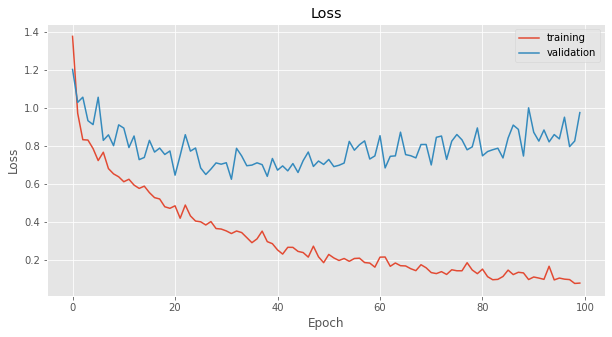

In [15]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 100), history.history["loss"], label="training")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

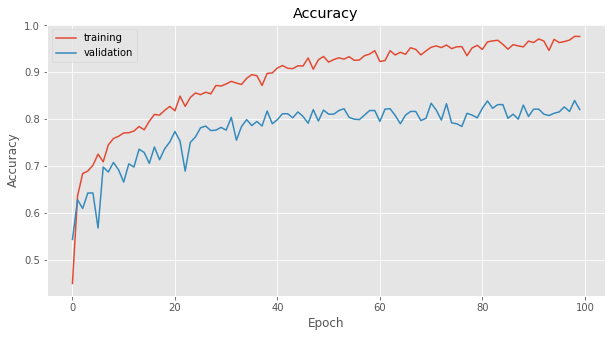

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 100), history.history["accuracy"], label="training")
plt.plot(np.arange(0, 100), history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [17]:
print(train_generator.class_indices)

{'battery': 0, 'cardboard': 1, 'green-glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5}


Mencoba mendeteksi gambar

Saving cardboard13.jpg to cardboard13.jpg
cardboard13.jpg
cardboard


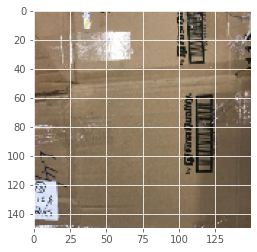

In [20]:
from tensorflow.keras.preprocessing import image
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)
  output_class=np.argmax(classes)
  print(fn)
  if output_class==0:
   print('battery')
  elif output_class==1:
    print('cardboard')
  elif output_class==2:
   print('green glass')
  elif output_class==3:
   print('metal')
  elif output_class==4:
   print('paper')
  elif output_class==5:
   print('plastic')
  else:
    print("tidak diketahui")

Mengubah model menjadi bentuk tflite

In [21]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [23]:
tflite_model_file = pathlib.Path('model-wahyu.tflite')
tflite_model_file.write_bytes(tflite_model)

27339680